In [77]:
import cv2
import imutils
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [78]:
# set the folder of the puzzle
dir_folder = './saturn'

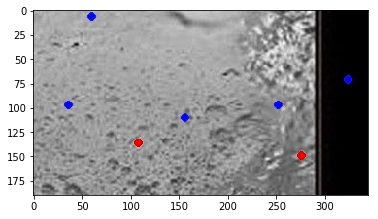

In [79]:
# let's do some image processing on one piece of puzzle first to get the coordinate 
img_name = '0o2NCQxNlGKZgPSz.jpg'
image = cv2.imread(os.path.join(dir_folder,img_name))
height, width = image.shape[:2]
plt.imshow(image)

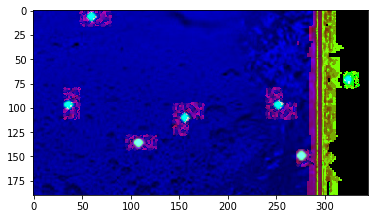

In [80]:
# change the color-space from BGR to HSV
image_to_process = image.copy()
image_to_process = cv2.cvtColor(image_to_process, cv2.COLOR_BGR2HSV)
plt.imshow(image_to_process)

In [81]:
# define the lower and upper range of red and blue
# set up the counter
colours = ['red','blue']
counter = {}
for colour in colours:   
    counter[colour] = 0
    if colour == 'red':
        lower = np.array([110,200,200])
        upper = np.array([130,255,255])
    elif colour == 'blue':
        lower = np.array([0,210,210])
        upper = np.array([20,255,255])

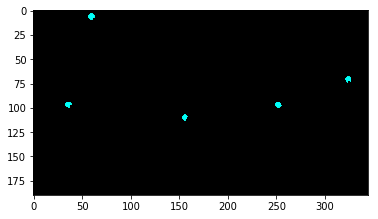

In [82]:
# find the colour within the HSV range of blue and apply the mask 
image_mask = cv2.inRange(image_to_process, lower, upper)
image_res = cv2.bitwise_and(image_to_process, image_to_process, mask=image_mask)
plt.imshow(image_res)

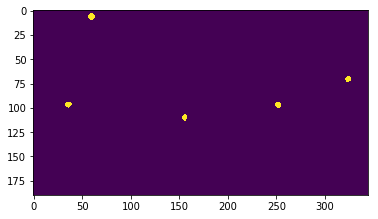

In [83]:
# convert to grayscale, blur it slightly and apply binary threshold
image_gray = cv2.cvtColor(image_res, cv2.COLOR_BGR2GRAY)
image_gray = cv2.GaussianBlur(image_gray, (5, 5), 0)
_,threshold = cv2.threshold(image_gray, 100, 255, cv2.THRESH_BINARY)
plt.imshow(threshold)

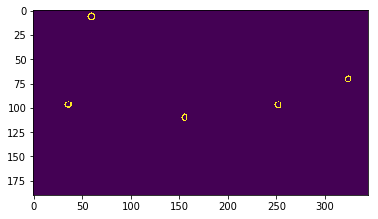

In [84]:
# perform edge detection, then perform dilation and erosion to close gaps between edges
image_edged = cv2.Canny(threshold, 50, 50) 
image_edged = cv2.dilate(image_edged, None, iterations=1)
image_edged = cv2.erode(image_edged, None, iterations=1)
plt.imshow(image_edged)

In [85]:
# find contours 
cnts = cv2.findContours(image_edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
# loop over the contours individually
for c in cnts:
    # ignore if the contour is too small
    if cv2.contourArea(c) < 2:
        continue
    counter[colour] += 1

#the counter for blue dots is:
print(counter[colour])

5


In [86]:
# now let's do the same thing for all pieces of puzzle and for both blue and red dots

#make a new dataframe
df = pd.DataFrame(columns=['img','row','col'])
for i,img in enumerate(os.listdir(dir_folder)):   
    # load image, convert to HSV
    image = cv2.imread(os.path.join(dir_folder,img))
    height, width = image.shape[:2]
    image_to_process = image.copy()
    image_to_process = cv2.cvtColor(image_to_process, cv2.COLOR_BGR2HSV) 

    colours = ['red','blue']
    counter = {}
    for colour in colours:   
        counter[colour] = 0
        if colour == 'red':
            lower = np.array([110,200,200])
            upper = np.array([130,255,255])
        elif colour == 'blue':
            lower = np.array([0,210,210])
            upper = np.array([20,255,255])

        # find the colour within the HSV range and apply the mask
        image_mask = cv2.inRange(image_to_process, lower, upper)
        image_res = cv2.bitwise_and(image_to_process, image_to_process, mask=image_mask)
        # convert to grayscale, blur it slightly and apply binary threshold
        image_gray = cv2.cvtColor(image_res, cv2.COLOR_BGR2GRAY)
        image_gray = cv2.GaussianBlur(image_gray, (5, 5), 0)
        _,threshold = cv2.threshold(image_gray, 100, 255, cv2.THRESH_BINARY)
        # perform edge detection, then perform dilation and erosion to close gaps between edges
        image_edged = cv2.Canny(threshold, 50, 50) 
        image_edged = cv2.dilate(image_edged, None, iterations=1)
        image_edged = cv2.erode(image_edged, None, iterations=1)
        # find contours 
        cnts = cv2.findContours(image_edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)

        # loop over the contours individually
        for c in cnts:
            # ignore if the contour is too small
            if cv2.contourArea(c) < 2:
                continue
            counter[colour] += 1
        # input dataframe with the image name, position of row and column
        df.loc[i,'img'] = img[:-4]
        if colour == 'blue':
            df.loc[i,'row'] = counter[colour]
        else:  
            df.loc[i,'col'] = counter[colour]
            
print(df)

                 img row col
0   0o2NCQxNlGKZgPSz   5   2
1   APKZbhzn3Pn6lZJb   5   1
2   b0CHXcko6XrG1h2F   4   4
3   b69xtdLYY0jIPhNS   2   2
4   dmWKBRbmexxECN2M   1   5
5   DNxGzgLTGF3zsqxU   2   5
6   dxamArCJd4EdAHYx   1   3
7   eYeHt5hJZGGn2Ycp   5   4
8   gnRBI3kwwAMTR587   4   5
9   h8gNkhysOkitV9F6   3   1
10  Ihjy13VXXH6QpVgN   3   4
11  K60yG2J1QungLyP5   2   4
12  llPwekNR6g7ukKZf   1   4
13  mpOGaulEgsgxx5DP   3   2
14  Q9cP3XCWNjOZuGKU   2   3
15  r2Z5aTQlC4qHjhCt   4   1
16  sc3vwRFEIrjf0L65   5   5
17  sVHrhx5LuPLt13bL   3   5
18  t2ARYoMw6p6KBqOj   4   3
19  tT3Dya28SXU61bdi   5   3
20  WR0Fn2G6idkYyFye   3   3
21  xhyCC55gXi7BbseG   4   2
22  yJHCV2FH31CBbiHZ   1   2
23  zqYyLxdvUy6icnPh   2   1
24  ZRwIMeXzmUg1Msn0   1   1


In [87]:
# sort the dataframe         
sorted_df = pd.DataFrame() 
for row in range(max(df['row'])):
    sort_df = df.loc[df['row'] == row+1]
    sort_df = sort_df.sort_values(by ='col' , ascending=True)
    sorted_df = pd.concat([sorted_df, sort_df], ignore_index=True)
print(sorted_df)

                 img row col
0   ZRwIMeXzmUg1Msn0   1   1
1   yJHCV2FH31CBbiHZ   1   2
2   dxamArCJd4EdAHYx   1   3
3   llPwekNR6g7ukKZf   1   4
4   dmWKBRbmexxECN2M   1   5
5   zqYyLxdvUy6icnPh   2   1
6   b69xtdLYY0jIPhNS   2   2
7   Q9cP3XCWNjOZuGKU   2   3
8   K60yG2J1QungLyP5   2   4
9   DNxGzgLTGF3zsqxU   2   5
10  h8gNkhysOkitV9F6   3   1
11  mpOGaulEgsgxx5DP   3   2
12  WR0Fn2G6idkYyFye   3   3
13  Ihjy13VXXH6QpVgN   3   4
14  sVHrhx5LuPLt13bL   3   5
15  r2Z5aTQlC4qHjhCt   4   1
16  xhyCC55gXi7BbseG   4   2
17  t2ARYoMw6p6KBqOj   4   3
18  b0CHXcko6XrG1h2F   4   4
19  gnRBI3kwwAMTR587   4   5
20  APKZbhzn3Pn6lZJb   5   1
21  0o2NCQxNlGKZgPSz   5   2
22  tT3Dya28SXU61bdi   5   3
23  eYeHt5hJZGGn2Ycp   5   4
24  sc3vwRFEIrjf0L65   5   5


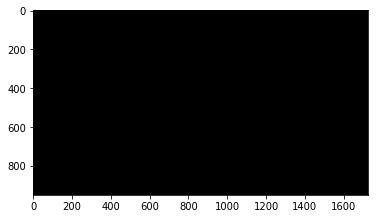

In [88]:
# make a new blank image with height and width of the final rearranged puzzle
canvas = np.zeros((height*sorted_df.loc[i,'col'],width*sorted_df.loc[i,'row'],3), np.uint8)
plt.imshow(canvas)

In [89]:
# paste patches on the image
for i in range(sorted_df.shape[0]):
    patch = cv2.imread(os.path.join(dir_folder, sorted_df.loc[i,'img'] + '.jpg'))
    x, y, channels = patch.shape
    height = (sorted_df.loc[i,'row']-1)*y
    width = (sorted_df.loc[i,'col']-1)*x
    canvas[width:width+x,height:height+y]=patch

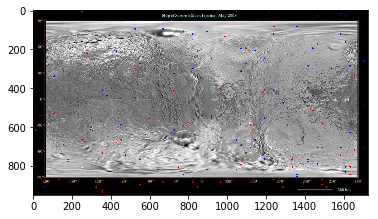

In [90]:
plt.imshow(canvas)

In [91]:
# resize the image into max of 800
if max(canvas.shape) > 800:
    scale_percent = 800 / max(canvas.shape) * 100 # percent of original size
    width = int(canvas.shape[1] * scale_percent / 100)
    height = int(canvas.shape[0] * scale_percent / 100)
    dim = (width, height)
    result = cv2.resize(canvas,dim)
else:
    result = canvas
    
print(result.shape)

(440, 800, 3)
